In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-hi/diabetes_012_health_indicators_BRFSS2015.csv
/kaggle/input/drugdata/Mouse_metadata.csv
/kaggle/input/drugdata/Study_results.csv


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# read files
mouse_data = pd.read_csv("/kaggle/input/drugdata/Mouse_metadata.csv")
study_data = pd.read_csv("/kaggle/input/drugdata/Study_results.csv")

mouse_data.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [5]:
study_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [6]:
# Merge the datasets on 'Mouse ID'
merged_data = pd.merge(mouse_data, study_data, on='Mouse ID', how='inner')

# Show the first few rows of the merged dataset
merged_data.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [7]:
# No missing values
merged_data.isnull().sum()

Mouse ID              0
Drug Regimen          0
Sex                   0
Age_months            0
Weight (g)            0
Timepoint             0
Tumor Volume (mm3)    0
Metastatic Sites      0
dtype: int64

In [8]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893 entries, 0 to 1892
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mouse ID            1893 non-null   object 
 1   Drug Regimen        1893 non-null   object 
 2   Sex                 1893 non-null   object 
 3   Age_months          1893 non-null   int64  
 4   Weight (g)          1893 non-null   int64  
 5   Timepoint           1893 non-null   int64  
 6   Tumor Volume (mm3)  1893 non-null   float64
 7   Metastatic Sites    1893 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 118.4+ KB


In [9]:
# Check for duplicates based on 'Mouse ID' and 'Timepoint'
duplicates_by_mouse_timepoint = merged_data[merged_data.duplicated(subset=['Mouse ID', 'Timepoint'])]

# Show the number of duplicates
print(f"Number of duplicate rows based on 'Mouse ID' and 'Timepoint': {duplicates_by_mouse_timepoint.shape[0]}")

# Optionally, display the duplicate rows
print(duplicates_by_mouse_timepoint)


Number of duplicate rows based on 'Mouse ID' and 'Timepoint': 5
    Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
909     g989     Propriva  Female          21          26          0   
911     g989     Propriva  Female          21          26          5   
913     g989     Propriva  Female          21          26         10   
915     g989     Propriva  Female          21          26         15   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
909           45.000000                 0  
911           47.570392                 0  
913           49.880528                 0  
915           53.442020                 0  
917           54.657650                 1  


In [10]:
# Remove duplicates based on 'Mouse ID' and 'Timepoint' while keeping the first occurrence
merged_data_cleaned = merged_data.drop_duplicates(subset=['Mouse ID', 'Timepoint'], keep='first')

# Verify that duplicates are removed
print(f"Data after removing duplicates: {merged_data_cleaned.shape[0]}")


Data after removing duplicates: 1888


In [11]:
# Describe the merged dataset and round to 1 decimal place
merged_data_cleaned.describe().round(1)

,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
count,1888.0,1888.0,1888.0,1888.0,1888.0
mean,12.8,25.7,19.6,50.4,1.0
std,7.2,3.9,14.1,8.9,1.1
min,1.0,15.0,0.0,22.1,0.0
25%,7.0,25.0,5.0,45.0,0.0
50%,13.0,27.0,20.0,49.0,1.0
75%,20.0,29.0,30.0,56.3,2.0
max,24.0,30.0,45.0,78.6,4.0


In [12]:
# Calculate summary statistics for each drug regimen
drug_stats = merged_data_cleaned.groupby('Drug Regimen').agg(
    Age_mean=('Age_months', 'mean'),
    Age_median=('Age_months', 'median'),
    Age_std=('Age_months', 'std'),
    Age_min=('Age_months', 'min'),
    Age_max=('Age_months', 'max'),
    
    Weight_mean=('Weight (g)', 'mean'),
    Weight_median=('Weight (g)', 'median'),
    Weight_std=('Weight (g)', 'std'),
    Weight_min=('Weight (g)', 'min'),
    Weight_max=('Weight (g)', 'max'),
    
    Tumor_Volume_mean=('Tumor Volume (mm3)', 'mean'),
    Tumor_Volume_median=('Tumor Volume (mm3)', 'median'),
    Tumor_Volume_std=('Tumor Volume (mm3)', 'std'),
    Tumor_Volume_min=('Tumor Volume (mm3)', 'min'),
    Tumor_Volume_max=('Tumor Volume (mm3)', 'max'),
    
    Metastatic_Sites_mean=('Metastatic Sites', 'mean'),
    Metastatic_Sites_median=('Metastatic Sites', 'median'),
    Metastatic_Sites_std=('Metastatic Sites', 'std'),
    Metastatic_Sites_min=('Metastatic Sites', 'min'),
    Metastatic_Sites_max=('Metastatic Sites', 'max')
).round(2)

# Display the statistics table
print("Summary Statistics for Each Drug Regimen:")
print(drug_stats)


Summary Statistics for Each Drug Regimen:
              Age_mean  Age_median  Age_std  Age_min  Age_max  Weight_mean  \
Drug Regimen                                                                 
Capomulin        13.46        16.5     7.72        1       24        19.97   
Ceftamin         13.25        12.0     8.07        2       24        27.40   
Infubinol        16.23        20.0     7.51        1       24        27.20   
Ketapril         15.66        18.0     6.02        1       24        27.86   
Naftisol         12.00         9.0     6.72        2       23        27.17   
Placebo          10.73        10.0     6.35        1       21        27.93   
Propriva         10.57         8.0     7.19        1       24        27.08   
Ramicane         10.68         9.0     5.95        1       23        19.68   
Stelasyn         12.78        14.0     7.94        1       23        27.86   
Zoniferol        12.60        12.5     5.79        2       24        27.69   

              Weight_

In [13]:
# Get unique drug regimens
unique_drugs = merged_data_cleaned['Drug Regimen'].unique()

# Print unique drug regimens
print("Unique Drug Regimens:")
print(unique_drugs)


Unique Drug Regimens:
['Ramicane' 'Capomulin' 'Infubinol' 'Placebo' 'Ceftamin' 'Stelasyn'
 'Zoniferol' 'Ketapril' 'Propriva' 'Naftisol']


## **Placebo vs Capomulin**

In [14]:
# Filter the dataset for 'Capomulin' drug regimen
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Get value counts for Age when the drug is Capomulin
Age_counts_capomulin = capomulin_data['Age_months'].value_counts()

# Display the result in ascending order
print(Age_counts_capomulin.sort_index(ascending=True))


Age_months
1     20
3     30
7     20
8     10
9     10
12    10
16    15
17    30
18    10
19    10
20    10
21     8
22    24
23    13
24    10
Name: count, dtype: int64


In [15]:
# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Combine both datasets to include Placebo and Capomulin data
combined_data = pd.concat([placebo_data, capomulin_data])

# Filter the data for Age_months between 1 and 24
filtered_data = combined_data[combined_data['Age_months'].between(1, 24)]

# Perform value counts for Age_months and Drug Regimen to see at which months both drugs are present
age_drug_counts = filtered_data.groupby('Age_months')['Drug Regimen'].value_counts().unstack(fill_value=0)

# Display the result
print(age_drug_counts)

Drug Regimen  Capomulin  Placebo
Age_months                      
1                    20       10
2                     0        7
3                    30       13
4                     0        9
5                     0       12
6                     0       13
7                    20       10
8                    10        0
9                    10       10
10                    0       10
12                   10       10
13                    0       10
14                    0        5
16                   15       12
17                   30       20
18                   10        6
19                   10        4
20                   10       10
21                    8       10
22                   24        0
23                   13        0
24                   10        0


In [16]:
# Filter the data for Age = 1 or Age = 2 months
filtered_data = merged_data_cleaned[merged_data_cleaned['Age_months'].isin([5, 6])]

# Grouping by 'Age_months' and 'Timepoint' to get the count of occurrences for specific ages
timepoint_counts_by_age_filtered = filtered_data.groupby(['Age_months', 'Timepoint']).size().reset_index(name='Count')

# Display the result
print(timepoint_counts_by_age_filtered)

    Age_months  Timepoint  Count
0            5          0     12
1            5          5     11
2            5         10      9
3            5         15      8
4            5         20      6
5            5         25      5
6            5         30      5
7            5         35      3
8            5         40      2
9            5         45      2
10           6          0      8
11           6          5      8
12           6         10      8
13           6         15      7
14           6         20      7
15           6         25      6
16           6         30      4
17           6         35      3
18           6         40      2
19           6         45      1


Insights:

* Each age group (e.g., 5 months) is evaluated at 9 different timepoints (ranging from 0 to 45 days, with intervals of 5 days).

* The number of observations per timepoint decreases as the study progresses. For example, at the start (timepoint 0), there are 12 mice observed, but by the end (timepoint 45), only 2 mice are recorded for age 5 months.

<ipython-input-17-6759aaab7448>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data['Drug'] = 'Placebo'
<ipython-input-17-6759aaab7448>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capomulin_data['Drug'] = 'Capomulin'


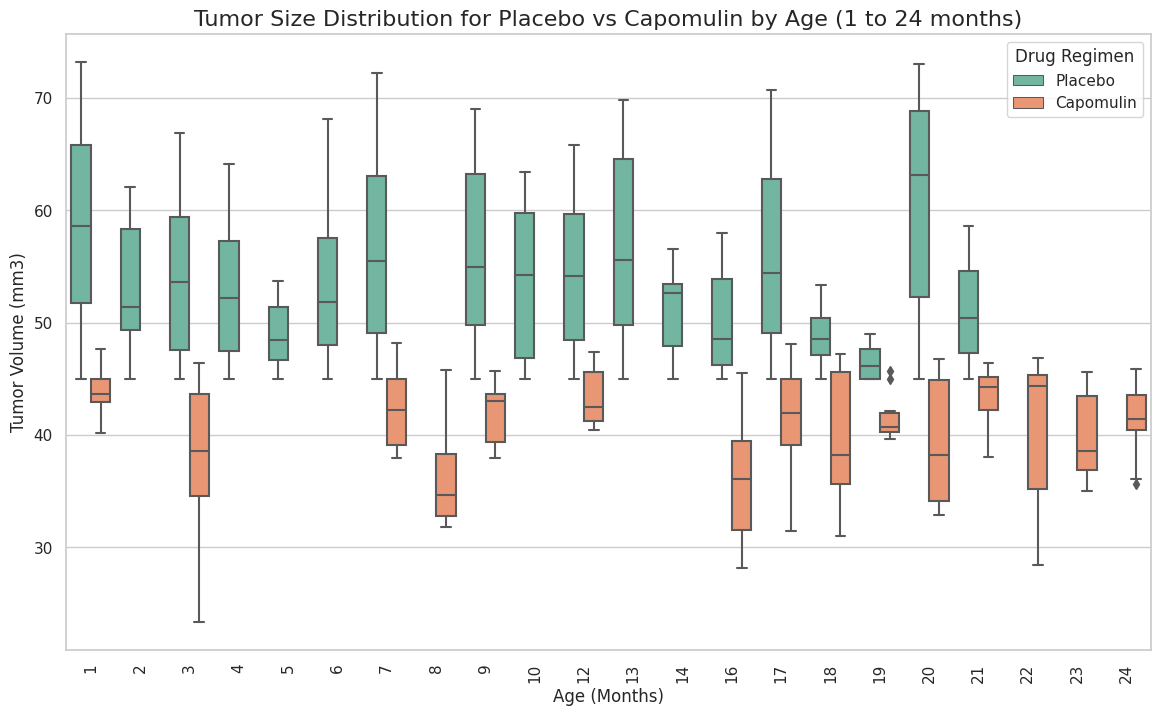

In [17]:

# Set up the plotting style for better visual appearance
sns.set(style="whitegrid")

# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Combine the Placebo and Capomulin data into a single dataframe with 'Drug' column to differentiate them
placebo_data['Drug'] = 'Placebo'
capomulin_data['Drug'] = 'Capomulin'

# Combine both datasets for plotting
combined_data = pd.concat([placebo_data, capomulin_data])

# Create a boxplot for tumor volume at each age (1 to 24 months) for both Placebo and Capomulin
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_data, x='Age_months', y='Tumor Volume (mm3)', hue='Drug', palette='Set2')

# Add titles and labels
plt.title('Tumor Size Distribution for Placebo vs Capomulin by Age (1 to 24 months)', fontsize=16)
plt.xlabel('Age (Months)', fontsize=12)
plt.ylabel('Tumor Volume (mm3)', fontsize=12)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.legend(title='Drug Regimen')
plt.show()



<ipython-input-18-9a3afd459281>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data['Drug'] = 'Placebo'
<ipython-input-18-9a3afd459281>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capomulin_data['Drug'] = 'Capomulin'
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/

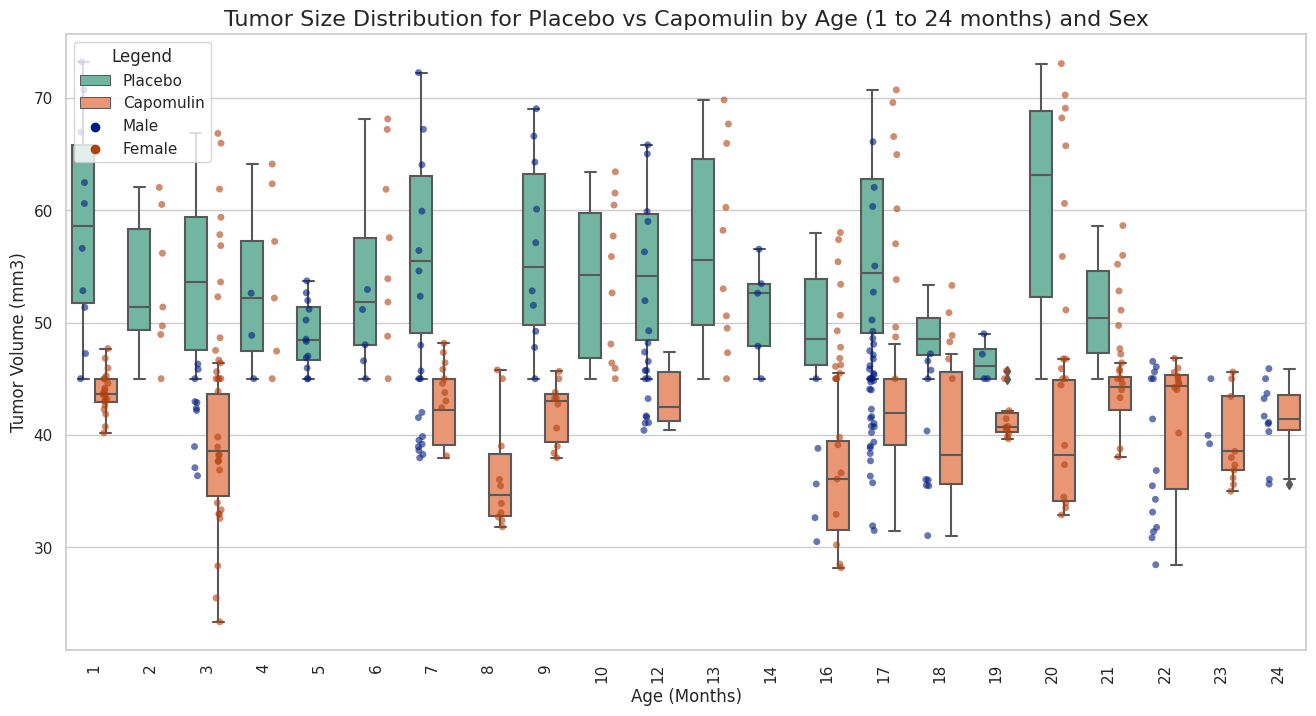

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style for better visual appearance
sns.set(style="whitegrid")

# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Add 'Drug' column to differentiate between Placebo and Capomulin
placebo_data['Drug'] = 'Placebo'
capomulin_data['Drug'] = 'Capomulin'

# Combine both datasets for plotting
combined_data = pd.concat([placebo_data, capomulin_data])

# Create a boxplot for tumor volume at each age (1 to 24 months), broken down by Drug and Sex
plt.figure(figsize=(16, 8))
sns.boxplot(data=combined_data, x='Age_months', y='Tumor Volume (mm3)', hue='Drug', 
            palette='Set2', dodge=True)

# Add additional layer for Sex as a subplot, making it facet style
sns.stripplot(data=combined_data, x='Age_months', y='Tumor Volume (mm3)', hue='Sex', 
              dodge=True, marker='o', alpha=0.6, palette='dark')

# Add titles and labels
plt.title('Tumor Size Distribution for Placebo vs Capomulin by Age (1 to 24 months) and Sex', fontsize=16)
plt.xlabel('Age (Months)', fontsize=12)
plt.ylabel('Tumor Volume (mm3)', fontsize=12)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Display the legend and show the plot
plt.legend(title='Legend', loc='upper left')
plt.show()


<ipython-input-19-e3b90ecffd78>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_1_month['Drug'] = 'Placebo'
<ipython-input-19-e3b90ecffd78>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capomulin_data_1_month['Drug'] = 'Capomulin'
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

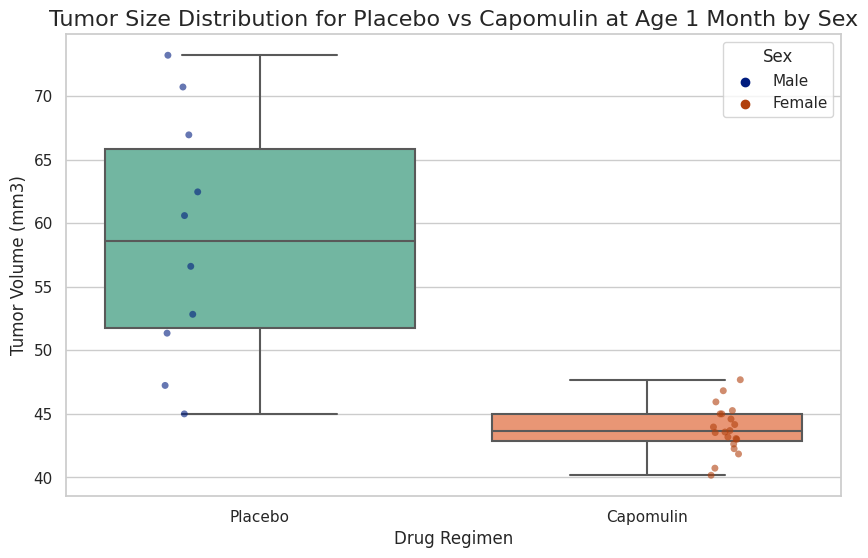

In [19]:
# Age = 1 month

# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Further filter data for Age = 1 month
placebo_data_1_month = placebo_data[placebo_data['Age_months'] == 1]
capomulin_data_1_month = capomulin_data[capomulin_data['Age_months'] == 1]

# Add 'Drug' column to differentiate between Placebo and Capomulin
placebo_data_1_month['Drug'] = 'Placebo'
capomulin_data_1_month['Drug'] = 'Capomulin'

# Combine both datasets for plotting
combined_data_1_month = pd.concat([placebo_data_1_month, capomulin_data_1_month])

# Create a boxplot for tumor volume at Age = 1 month, broken down by Drug and Sex
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data_1_month, x='Drug', y='Tumor Volume (mm3)', 
            palette='Set2', dodge=True)

# Add additional layer for Sex as a subplot, making it facet style
sns.stripplot(data=combined_data_1_month, x='Drug', y='Tumor Volume (mm3)', hue='Sex', 
              dodge=True, marker='o', alpha=0.6, palette='dark')

# Add titles and labels
plt.title('Tumor Size Distribution for Placebo vs Capomulin at Age 1 Month by Sex', fontsize=16)
plt.xlabel('Drug Regimen', fontsize=12)
plt.ylabel('Tumor Volume (mm3)', fontsize=12)

# Display the legend and show the plot
plt.legend(title='Sex', loc='upper right')
plt.show()


<ipython-input-20-a2cf7d35a395>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_age['Drug'] = 'Placebo'
<ipython-input-20-a2cf7d35a395>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capomulin_data_age['Drug'] = 'Capomulin'
<ipython-input-20-a2cf7d35a395>:34: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_data_age, x='Drug', y='Tumor Volume (mm3)',
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

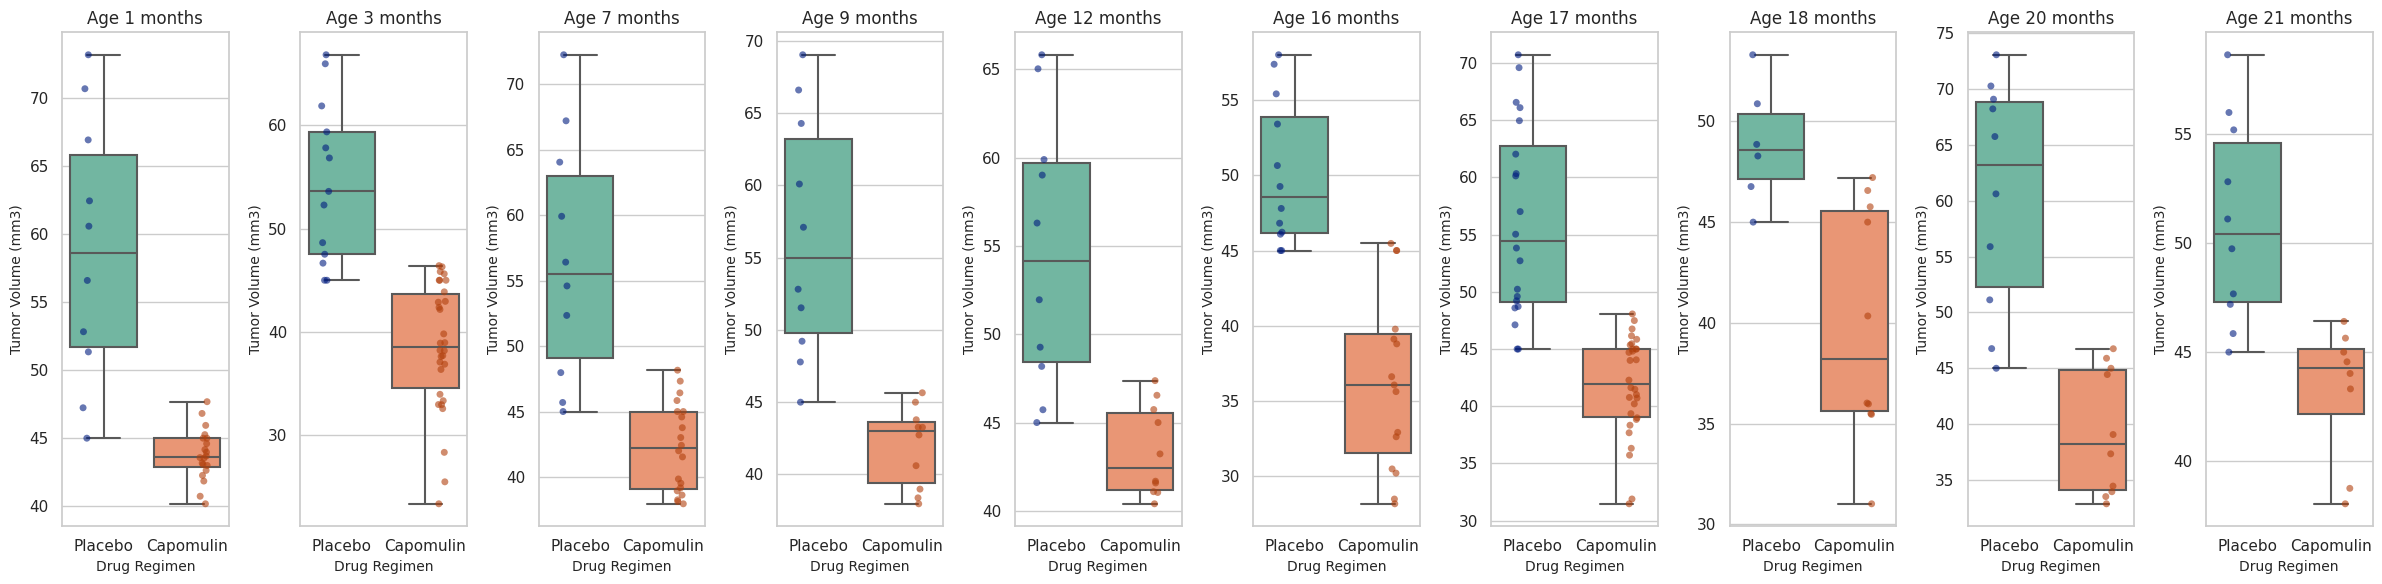

In [20]:
# Tumor Volume

# List of the specific ages to consider
ages_to_plot = [1, 3, 7, 9, 12, 16, 17, 18, 20, 21]

# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Set up the plot size (9 plots in a single row)
plt.figure(figsize=(24, 6))  # Adjust the width to fit all plots

# Loop through the ages and create the plots
for i, age in enumerate(ages_to_plot):
    # Filter the data for the current age
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    capomulin_data_age = capomulin_data[capomulin_data['Age_months'] == age]

    # Add 'Drug' column to differentiate between Placebo and Capomulin
    placebo_data_age['Drug'] = 'Placebo'
    capomulin_data_age['Drug'] = 'Capomulin'

    # Combine both datasets for the current age
    combined_data_age = pd.concat([placebo_data_age, capomulin_data_age])

    # Create a subplot (1 row, 9 columns)
    plt.subplot(1, 10, i + 1)

    # Create a boxplot for tumor volume, broken down by Drug
    sns.boxplot(data=combined_data_age, x='Drug', y='Tumor Volume (mm3)', 
                palette='Set2')

    # Add stripplot for additional layer of information
    sns.stripplot(data=combined_data_age, x='Drug', y='Tumor Volume (mm3)', 
                  marker='o', alpha=0.6, palette='dark', dodge=True)

    # Add titles and labels
    plt.title(f'Age {age} months', fontsize=12)
    plt.xlabel('Drug Regimen', fontsize=10)
    plt.ylabel('Tumor Volume (mm3)', fontsize=10)
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-21-de0ee98d1b05>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_age['Drug'] = 'Placebo'
<ipython-input-21-de0ee98d1b05>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capomulin_data_age['Drug'] = 'Capomulin'
<ipython-input-21-de0ee98d1b05>:32: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_data_age, x='Drug', y='Weight (g)',
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

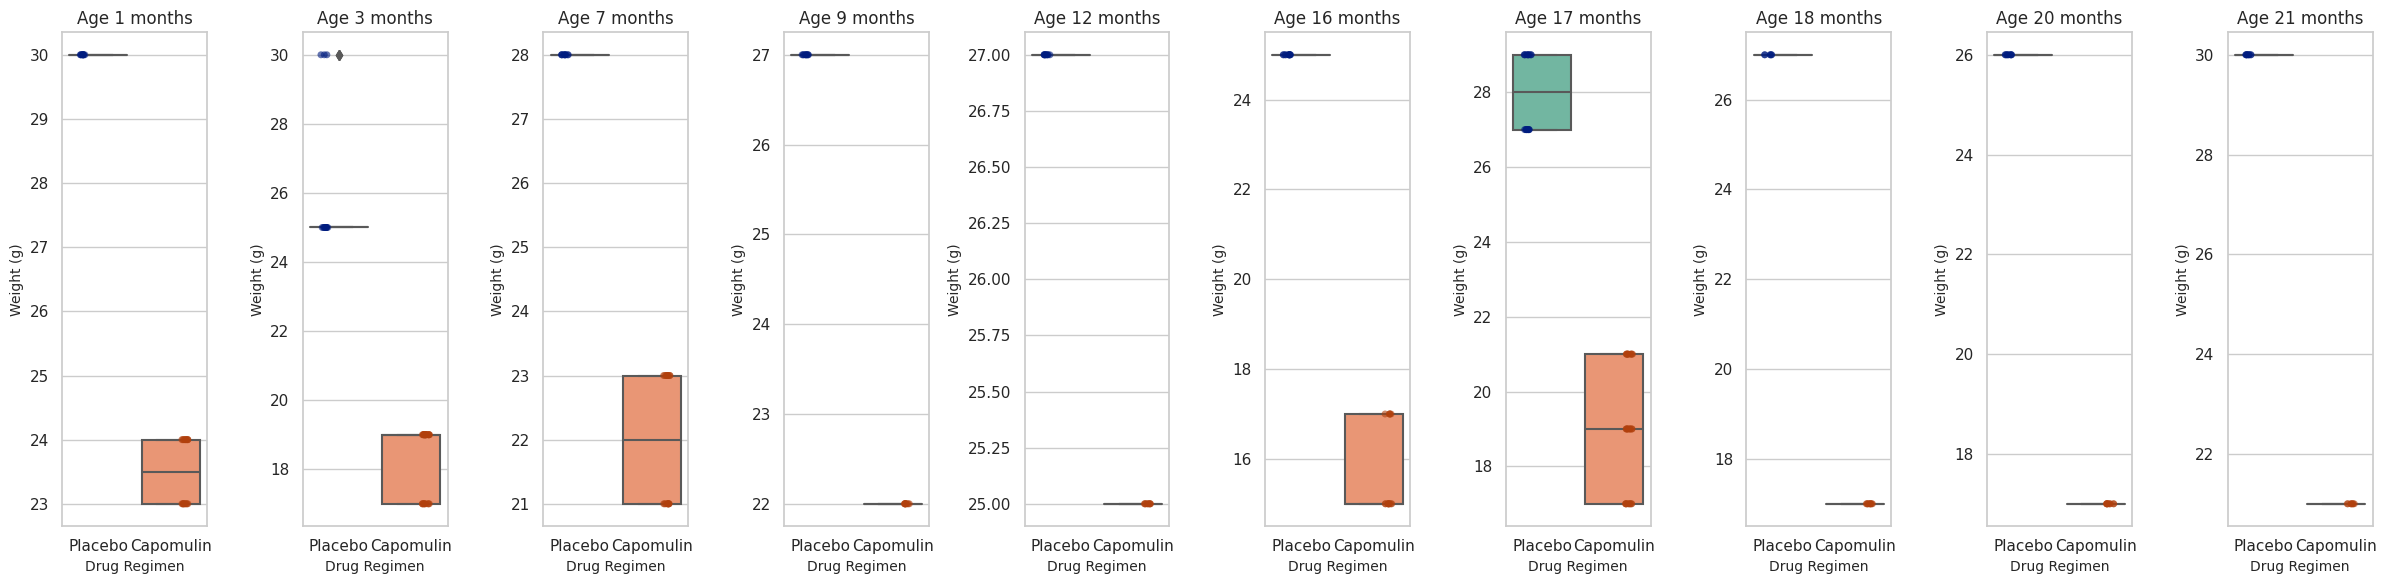

In [21]:
# Weight (g)

# List of the specific ages to consider
ages_to_plot = [1, 3, 7, 9, 12, 16, 17, 18, 20, 21]

# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Set up the plot size (9 plots in a single row)
plt.figure(figsize=(24, 6))  # Adjust the width to fit all plots

# Loop through the ages and create the plots
for i, age in enumerate(ages_to_plot):
    # Filter the data for the current age
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    capomulin_data_age = capomulin_data[capomulin_data['Age_months'] == age]

    # Add 'Drug' column to differentiate between Placebo and Capomulin
    placebo_data_age['Drug'] = 'Placebo'
    capomulin_data_age['Drug'] = 'Capomulin'

    # Combine both datasets for the current age
    combined_data_age = pd.concat([placebo_data_age, capomulin_data_age])

    # Create a subplot (1 row, 9 columns)
    plt.subplot(1, 10, i + 1)  # Create a boxplot for weight, broken down by Drug
    sns.boxplot(data=combined_data_age, x='Drug', y='Weight (g)', 
                palette='Set2')

    # Add stripplot for additional layer of information
    sns.stripplot(data=combined_data_age, x='Drug', y='Weight (g)', 
                  marker='o', alpha=0.6, palette='dark', dodge=True)

    # Add titles and labels
    plt.title(f'Age {age} months', fontsize=12)
    plt.xlabel('Drug Regimen', fontsize=10)
    plt.ylabel('Weight (g)', fontsize=10)
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# List of the specific ages to consider
ages_to_plot = [1, 3, 7, 9, 12, 16, 17, 18, 20, 21]

# Loop through each age and get the value counts for Metastatic Sites
for age in ages_to_plot:
    # Filter data for current age and both drug regimens
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    capomulin_data_age = capomulin_data[capomulin_data['Age_months'] == age]
    
    # Combine the data for the current age
    combined_data_age = pd.concat([placebo_data_age, capomulin_data_age])

    # Get the value counts for Metastatic Sites by drug regimen and age
    metastatic_counts = combined_data_age.groupby(['Age_months', 'Drug Regimen'])['Metastatic Sites'].value_counts().unstack(fill_value=0)
    
    print(f"Metastatic Sites value counts for Age {age} months:")
    print(metastatic_counts)
    print("\n")


Metastatic Sites value counts for Age 1 months:
Metastatic Sites          0  1  2  3
Age_months Drug Regimen             
1          Capomulin     12  8  0  0
           Placebo        2  4  1  3


Metastatic Sites value counts for Age 3 months:
Metastatic Sites         0   1
Age_months Drug Regimen       
3          Capomulin     9  21
           Placebo       4   9


Metastatic Sites value counts for Age 7 months:
Metastatic Sites          0  1  2  3  4
Age_months Drug Regimen                
7          Capomulin     14  6  0  0  0
           Placebo        1  2  1  4  2


Metastatic Sites value counts for Age 9 months:
Metastatic Sites         0  1  2  3
Age_months Drug Regimen            
9          Capomulin     5  3  2  0
           Placebo       4  1  4  1


Metastatic Sites value counts for Age 12 months:
Metastatic Sites         0  1  2
Age_months Drug Regimen         
12         Capomulin     4  3  3
           Placebo       5  3  2


Metastatic Sites value counts for Age 16 

<ipython-input-23-0348c787b8d6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_age.loc[:, 'Drug'] = 'Placebo'  # Use .loc[] to avoid the warning
<ipython-input-23-0348c787b8d6>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capomulin_data_age.loc[:, 'Drug'] = 'Capomulin'
<ipython-input-23-0348c787b8d6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

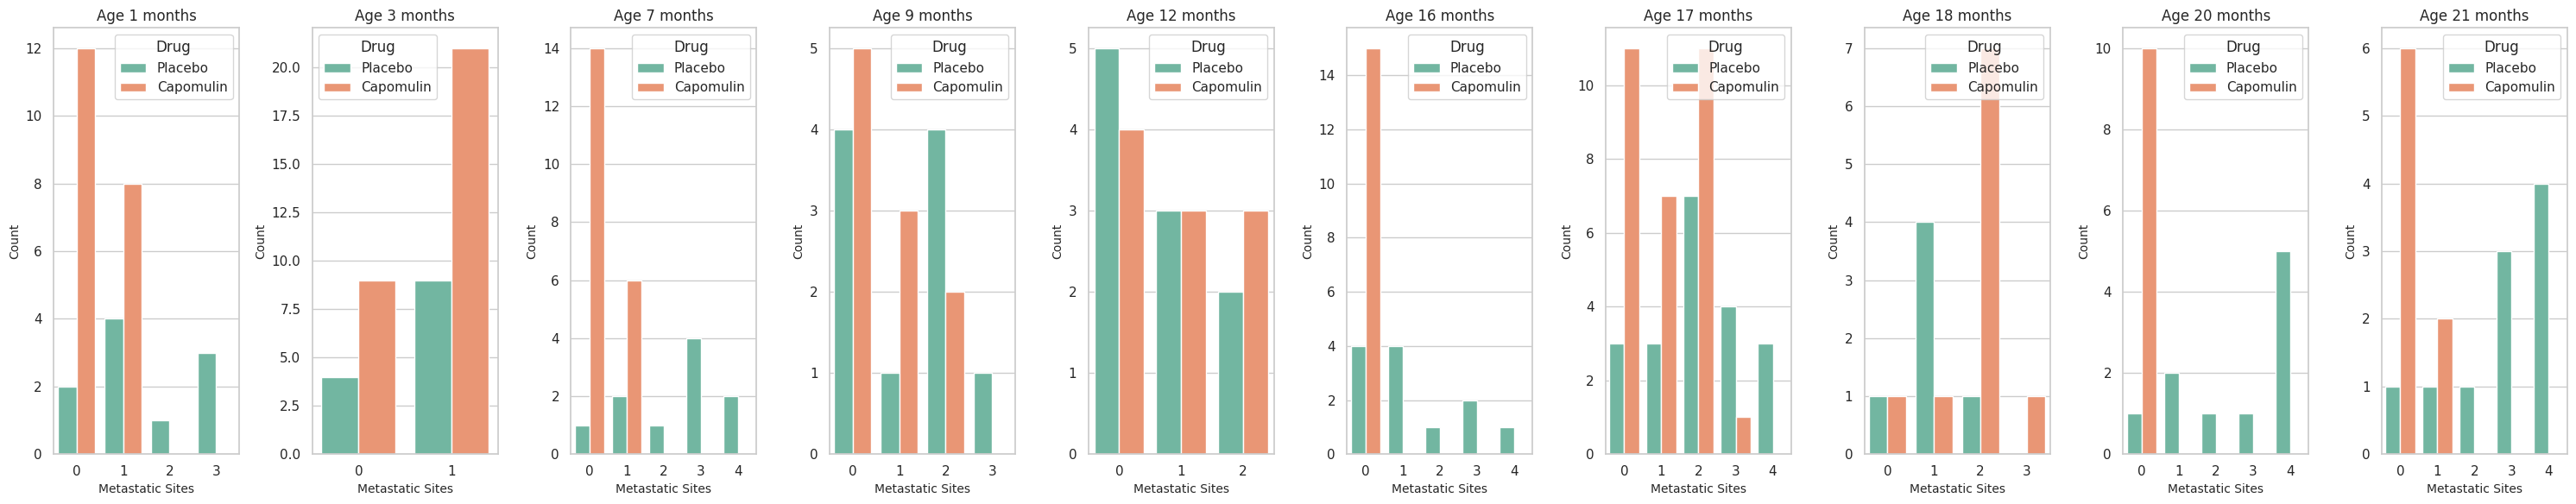

In [23]:
# Metastatic Sites

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# Suppress SettingWithCopyWarning (optional, if you want to avoid the warnings)
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

# List of the specific ages to consider
ages_to_plot = [1, 3, 7, 9, 12, 16, 17, 18, 20, 21]

# Filter data for Placebo and Capomulin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
capomulin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Capomulin']

# Set up the plot size (10 plots in a single row)
plt.figure(figsize=(30, 6))  # Adjust the width to fit all 10 plots

# Loop through the ages and create the plots
for i, age in enumerate(ages_to_plot):
    # Filter the data for the current age
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    capomulin_data_age = capomulin_data[capomulin_data['Age_months'] == age]

    # Add 'Drug' column to differentiate between Placebo and Capomulin
    placebo_data_age.loc[:, 'Drug'] = 'Placebo'  # Use .loc[] to avoid the warning
    capomulin_data_age.loc[:, 'Drug'] = 'Capomulin'

    # Combine both datasets for the current age
    combined_data_age = pd.concat([placebo_data_age, capomulin_data_age])

    # Create a subplot (1 row, 10 columns)
    plt.subplot(1, 10, i + 1)  # Create a countplot for Metastatic Sites
    sns.countplot(data=combined_data_age, x='Metastatic Sites', hue='Drug', 
                  palette='Set2')

    # Add titles and labels
    plt.title(f'Age {age} months', fontsize=12)
    plt.xlabel('Metastatic Sites', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



<Figure size 1000x600 with 0 Axes>

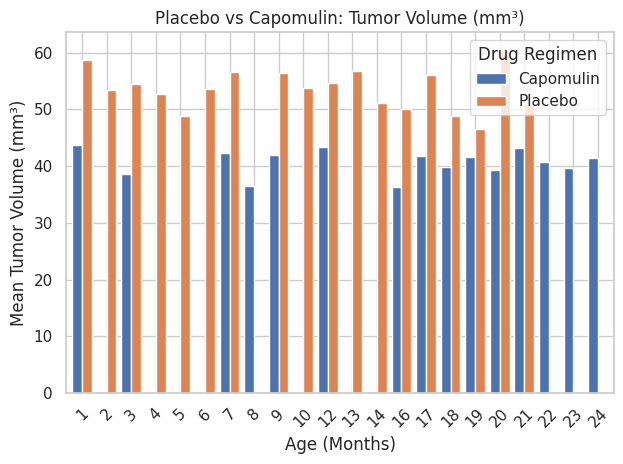

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data for Placebo and Capomulin
filtered_df = merged_data_cleaned[merged_data_cleaned['Drug Regimen'].isin(['Placebo', 'Capomulin'])]

# Group by Age_months and Drug Regimen, then calculate mean tumor volume
mean_tumor_volume = filtered_df.groupby(['Age_months', 'Drug Regimen'])['Tumor Volume (mm3)'].mean().reset_index()

# Pivot the dataframe to have 'Age_months' as the index and columns for Placebo and Capomulin
tumor_volume_pivot = mean_tumor_volume.pivot(index='Age_months', columns='Drug Regimen', values='Tumor Volume (mm3)')

# Plotting
plt.figure(figsize=(10,6))
tumor_volume_pivot.plot(kind='bar', width=0.8)
plt.title('Placebo vs Capomulin: Tumor Volume (mm³)')
plt.xlabel('Age (Months)')
plt.ylabel('Mean Tumor Volume (mm³)')  # Updated label for clarity
plt.xticks(rotation=45)
plt.legend(title='Drug Regimen')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

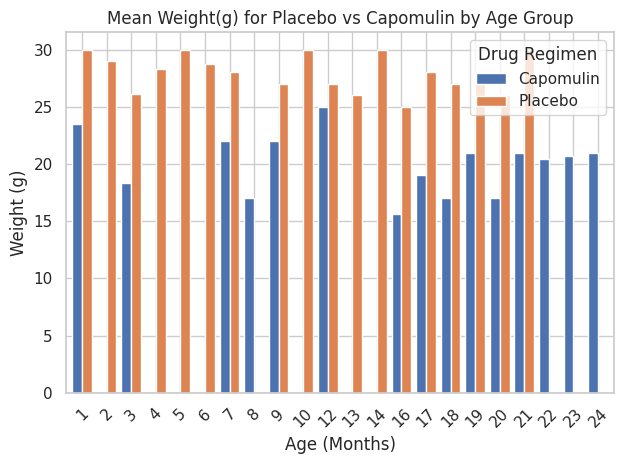

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data for Placebo and Capomulin
filtered_df = merged_data_cleaned[merged_data_cleaned['Drug Regimen'].isin(['Placebo', 'Capomulin'])]

# Group by Age_months and Drug Regimen, then calculate mean weight
mean_weight = filtered_df.groupby(['Age_months', 'Drug Regimen'])['Weight (g)'].mean().reset_index()

# Pivot the dataframe to have 'Age_months' as the index and columns for Placebo and Capomulin
weight_pivot = mean_weight.pivot(index='Age_months', columns='Drug Regimen', values='Weight (g)')

# Plotting
plt.figure(figsize=(10,6))
weight_pivot.plot(kind='bar', width=0.8)
plt.title('Mean Weight(g) for Placebo vs Capomulin by Age Group')
plt.xlabel('Age (Months)')
plt.ylabel('Weight (g)')  # Updated label for clarity
plt.xticks(rotation=45)
plt.legend(title='Drug Regimen')
plt.tight_layout()
plt.show()


In [25]:
merged_data_cleaned.columns

Index(['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)',
       'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'],
      dtype='object')

In [33]:

# ANOVA for tumor volume 
import pandas as pd
import scipy.stats as stats

# Filter the data to include only 'Placebo' and 'Capomulin' drug regimens
filtered_df = merged_data_cleaned[merged_data_cleaned['Drug Regimen'].isin(['Placebo', 'Capomulin'])]

# Define the age groups to analyze
age_groups = [1, 3, 7, 9, 12, 16, 17, 18, 20, 21]

# Perform ANOVA for each age group
anova_results = {}
for age in age_groups:
    # Filter the data for the specific age group
    age_data = filtered_df[filtered_df['Age_months'] == age]
    
    # Perform the ANOVA test between 'Placebo' and 'Capomulin'
    placebo_data = age_data[age_data['Drug Regimen'] == 'Placebo']['Tumor Volume (mm3)']
    capomulin_data = age_data[age_data['Drug Regimen'] == 'Capomulin']['Tumor Volume (mm3)']
    
    # Conduct one-way ANOVA
    f_stat, p_value = stats.f_oneway(placebo_data, capomulin_data)
    
    # Store the result in a dictionary
    anova_results[age] = {
        'F-statistic': f_stat,
        'p-value': p_value
    }

# Create a DataFrame to display the results
anova_df = pd.DataFrame(anova_results).T
anova_df.columns = ['F-statistic', 'p-value']

# Display the ANOVA results
print(anova_df)


    F-statistic       p-value
1     45.038467  2.762834e-07
3     51.550818  9.194732e-09
7     38.489261  1.058978e-06
9     26.520244  6.721190e-05
12    19.227358  3.571974e-04
16    42.839658  7.416384e-07
17    62.780128  2.875202e-10
18    12.035384  3.758360e-03
20    32.744183  2.000324e-05
21    16.094926  1.006638e-03


In [34]:
# ANOVA for Weight (g)

import pandas as pd
import scipy.stats as stats

# Filter the data to include only 'Placebo' and 'Capomulin' drug regimens
filtered_df = merged_data_cleaned[merged_data_cleaned['Drug Regimen'].isin(['Placebo', 'Capomulin'])]

# Define the age groups to analyze
age_groups = [1, 3, 7, 9, 12, 16, 17, 18, 20, 21]

# Perform ANOVA for each age group
anova_results = {}
for age in age_groups:
    # Filter the data for the specific age group
    age_data = filtered_df[filtered_df['Age_months'] == age]
    
    # Perform the ANOVA test between 'Placebo' and 'Capomulin' for Weight (g)
    placebo_data = age_data[age_data['Drug Regimen'] == 'Placebo']['Weight (g)']
    capomulin_data = age_data[age_data['Drug Regimen'] == 'Capomulin']['Weight (g)']
    
    # Conduct one-way ANOVA
    f_stat, p_value = stats.f_oneway(placebo_data, capomulin_data)
    
    # Store the result in a dictionary
    anova_results[age] = {
        'F-statistic': f_stat,
        'p-value': p_value
    }

# Create a DataFrame to display the results
anova_df = pd.DataFrame(anova_results).T
anova_df.columns = ['F-statistic', 'p-value']
print(anova_df)


    F-statistic       p-value
1   1577.333333  3.633689e-26
3    269.599562  1.241851e-19
7    336.000000  3.939668e-17
9           inf  0.000000e+00
12          inf  0.000000e+00
16  1088.888889  3.907649e-22
17   466.560000  2.263382e-26
18          inf  0.000000e+00
20          inf  0.000000e+00
21          inf  0.000000e+00


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
